# Projet MALAP

## Réalisé par Tong Zhao, Quentin Duchemin et Pierre Boyeau

In [2]:
import  numpy as np
import matplotlib.pyplot as plt
from tools import *
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy import stats
from sklearn.svm import SVC
from mnist import MNIST

In [5]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =  list( zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    
xusps,yusps = load_usps("datas/usps/USPS_train.txt")

## Data processing

In [3]:
def analyse_data(y, L):
    label_L, count_L = np.unique(y[:L], return_counts=True)
    label_U, count_U = np.unique(y[L:], return_counts=True)
    
    
    if np.any(label_L != label_U):
        print("Test data has unknown labels. Please re-select again.")
        return
    
    colors = np.random.rand(len(label_L), 3,1)
    plt.figure(figsize=(6, 6))
    
    for i, label in enumerate(label_L):
        plt.bar(1.5, count_L[i], width=0.3, bottom=np.sum(count_L[:i]), alpha=0.8, color=colors[i], label = str(label))
        plt.bar(3, count_U[i], width=0.3, bottom=np.sum(count_U[:i]), alpha=0.8, color=colors[i])
    
    plt.title("The paritition of dataset")
    plt.xticks([1.5, 3], ['labeled', 'unlabeled'])
    plt.grid()
    plt.legend()
    plt.show()

### USPS dataset

Load USPS data...

Data shape: 1742 * 256

Labeled num: 88

Unlabeld num: 1654


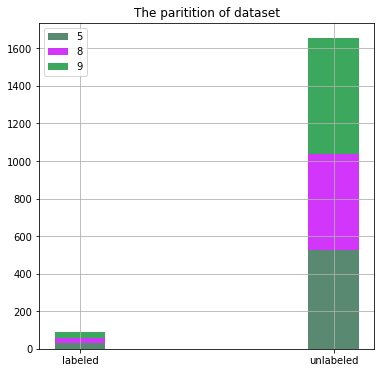

In [74]:
# Définition de la base d'apprentissage
xuspstrain,yuspstrain = get_usps([5, 8, 9],xusps,yusps)
data = xuspstrain
(n,m) = np.shape(data)

# shuffle data
idx = np.random.permutation(n)
data = data[idx]
yuspstrain = yuspstrain[idx]

# Pourcentage de la base d'apprentissage non étiquettée
percent_u = 95./100.
# nombre de données non étiquettées
U = int(percent_u * n)
# nombre de données étiquettées
L =  n-U

# étiquettes connues
labels = yuspstrain[:L]
# étiquettes à prédire
labpredire = yuspstrain[L:]

print("Load USPS data...\n")
print("Data shape: %d * %d" % data.shape)
print("\nLabeled num: %d" % L)
print("\nUnlabeld num: %d" % U)
analyse_data(yuspstrain, L)

### Mnist

In [4]:
def select_data(a, x, y):
    idx = np.in1d(y, a)
    return x[idx], y[idx]

In [5]:
mndata = MNIST('./datas/Mnist/')
xmnist, ymnist = mndata.load_training()
xmnist, ymnist = np.array(xmnist), np.array(ymnist)

Load Mnist data...

Data shape: 11973 * 784

Labeled num: 599

Unlabeld num: 11374


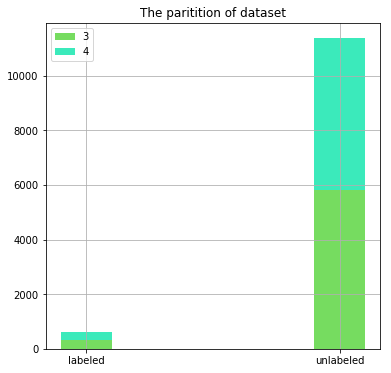

In [7]:
xmnisttrain, ymnisttrain = select_data([3, 4], xmnist, ymnist)
data = xmnisttrain
(n,m) = np.shape(data)

# shuffle data
idx = np.random.permutation(n)
data = data[idx]
ymnisttrain = ymnisttrain[idx]

# Pourcentage de la base d'apprentissage non étiquettée
percent_u = 95./100.
# nombre de données non étiquettées
U = int(percent_u * n)
# nombre de données étiquettées
L =  n-U

# étiquettes connues
labels = ymnisttrain[:L]
# étiquettes à prédire
labpredire = ymnisttrain[L:]

print("Load Mnist data...\n")
print("Data shape: %d * %d" % data.shape)
print("\nLabeled num: %d" % L)
print("\nUnlabeld num: %d" % U)
analyse_data(ymnisttrain, L)

## Baseline 1 - K plus proche voisins 

In [8]:
class KNN:
    
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, labels):
        self.N = data.shape[0]
        L = labels.shape[0]
        
        # calculate distance
        self.W = cosine_distances(data[L:], data[:L])
        self.labels = labels
        
    def predict(self):
        
        idx = np.argsort(self.W, axis = 1)[:, :self.k]
        bag = self.labels[idx]
        predict, _ = stats.mode(bag, axis = 1)
        
        return predict.reshape((-1))
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [9]:
M = KNN(10)
M.fit(data,labels)
print("The score of Diffusion by knn is %f" % M.score(labpredire))

The score of Diffusion by knn is 0.996307


In [82]:
def test_knn(data, labels, labpredire):
    lk = range(2, 30, 2)
    lscore = []
    
    for k in lk:
        M = KNN(k)
        M.fit(data, labels)
        lscore.append(M.score(labpredire))
        
    print("The best k: %d" % lk[np.argmax(np.array(lscore))])
    print("The best score: %f" % np.max(np.array(lscore)))
    plt.figure(figsize=(6, 6))
    plt.plot(lk, lscore)
    plt.title('The knn score influenced by k')
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.grid()
    plt.show()

The best result: 8


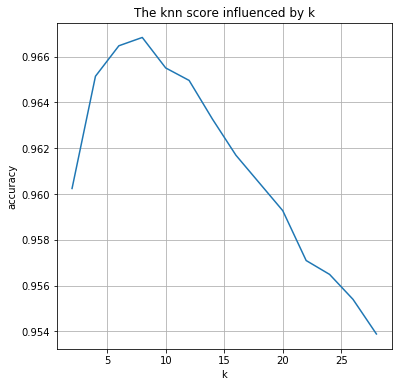

In [81]:
test_knn(data, labels, labpredire)

## Baseline 2 - SVM

In [11]:
clf = SVC(C=1.5)
clf.fit(data[:L], labels)
print("The score of SVM is %f" % (clf.predict(data[L:]) == labpredire).mean())

(11374,)
(11374,)
The score of SVM is 0.509671


In [13]:
def test_svm(data, y, L):
    lc = np.arange(1, 2, 0.3)
    lscore = []
    
    for c in lc:
        print c
        clf = SVC(C=c)
        clf.fit(data[:L], y[:L])
        lscore.append((clf.predict(data[L:]) == y[L:].reshape((-1))).mean())

    print("The best c: %f" % lc[np.argmax(np.array(lscore))])
    print("The best score: %f" % np.max(np.array(lscore)))
    plt.figure(figsize=(6, 6))
    plt.plot(lc, lscore)
    plt.title('The SVM score influenced by c')
    plt.xlabel('c')
    plt.ylabel('accuracy')
    plt.grid()
    plt.show()

1.0
1.3
1.6
1.9
The best c: 1.000000
The best score: 0.509671


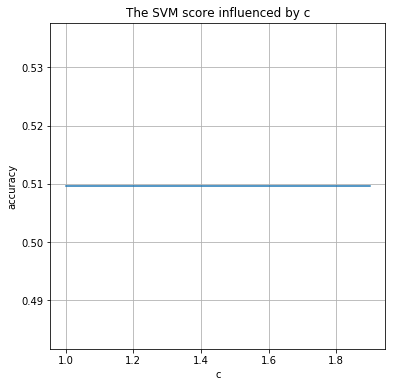

In [14]:
test_svm(data, ymnisttrain, L)

## 1. Classification using simply threshold

$$ f_u = (D_{uu} - W_{uu})^{-1} W_{ul} f_l$$

In [15]:
class DiffusionTRESH:
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)

        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        fu = np.dot(np.dot(np.linalg.inv(self.D[self.L:,self.L:] - self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self, data, labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(m)])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        
    def score(self, labels):
        return (self.predict()==labels).mean()


In [ ]:
M = DiffusionTRESH()
M.fit(data,labels)
print("The score of Diffusion by threshold is %f" % M.score(labpredire))


## 2. Incorporation of Class Prior : CMN with weights fixed by advance

In [73]:
class DiffusionCMN:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        desirable_proportions = y.sum(0) + 1
        fu = np.dot(np.dot(np.linalg.inv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * (desirable_proportions / fu.sum(0))

        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(m)])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [74]:
M = DiffusionCMN()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

The score of Diffusion by class prior is 0.986577


## 3. Incorporating External Classifiers - SVM

## 3.1 TRESH + SVM

In [81]:
class DiffusionTRESHSVM:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        fu = np.dot(np.dot(np.linalg.inv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * self.hu
        
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(m)])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        # train svm
        clf = SVC(C=2, probability = True)
        clf.fit(data[:self.L], labels)
        self.hu = clf.predict_proba(data[self.L:])
        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [ ]:
M = DiffusionTRESHSVM()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

## 3.2 Non fonctionnel : essai car doute sur la formule utilisée dans TRESHSVM

In [97]:
class DiffusionCMNSVM:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        P =  np.dot(np.linalg.inv(self.D),self.W)
        fu = np.dot(np.linalg.inv(np.eye(P.shape[0]-self.L)-(1-self.hu) * P[self.L:,self.L:]), np.dot((1-self.hu)*P[self.L:,:self.L], y) + np.dot(self.hu , self.pred_svm)) 
        
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
         
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(m)])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        # train svm
        clf = SVC(C=2, probability = True)
        clf.fit(data[:self.L], labels)
        self.hu = clf.predict_proba(data[L:])
        self.pred_svm = clf.predict(data[L:])
        print(np.shape(self.hu))
        print(np.shape(self.pred_svm))
        print(labels)

        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [ ]:
M = DiffusionCMNSVM()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

# TESTS

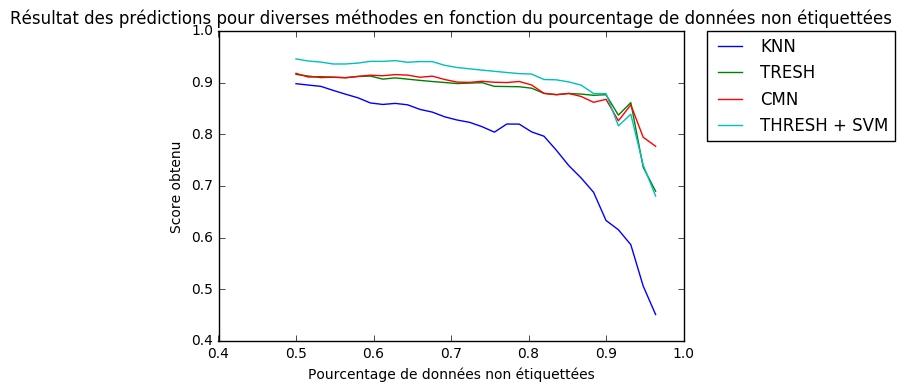

In [100]:
def resultats(xtrain,ytrain):
    (n,m) = np.shape(xtrain)

    # shuffle data
    idx = np.random.permutation(n)
    xtrain = xtrain[idx]
    ytrain = ytrain[idx]
    xtrain = xtrain[:1000,:]
    ytrain = ytrain[:1000]
    (n,m) = np.shape(xtrain)

    nb_tests = 30
    # Pourcentage de la base d'apprentissage non étiquettée
    list_percent_u = [((98-50)/100)*(i/nb_tests) + 50/100 for i in range(nb_tests)]
    score_KNN,score_thresh,score_CMN,score_threshsvm = [],[],[], []

    for percent_u in list_percent_u:
        # nombre de données non étiquettées
        U = int(percent_u * n)
        # nombre de données étiquettées
        L =  n-U
        # étiquettes connues
        labels = ytrain[:L]
        # étiquettes à prédire
        labpredire = ytrain[L:]
        M = KNN(10)
        M.fit(xtrain,labels)
        score_KNN.append(M.score(labpredire))
        M = DiffusionTRESH()
        M.fit(xtrain,labels)
        score_thresh.append(M.score(labpredire))
        M = DiffusionCMN()
        M.fit(xtrain,labels)
        score_CMN.append(M.score(labpredire))
        M = DiffusionTRESHSVM()
        M.fit(xtrain,labels)
        score_threshsvm.append(M.score(labpredire))
    plt.figure(figsize=(20, 8))
    plt.plot(list_percent_u,score_KNN,label = "KNN")
    plt.plot(list_percent_u,score_thresh,label = "TRESH")
    plt.plot(list_percent_u,score_CMN,label = "CMN")
    plt.plot(list_percent_u,score_threshsvm,label = "THRESH + SVM")
    plt.title("Résultat des prédictions pour diverses méthodes en fonction du pourcentage de données non étiquettées")
    plt.ylabel("Score obtenu")
    plt.xlabel("Pourcentage de données non étiquettées")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.show()


# Test sur les données USPS
xuspstrain,yuspstrain = load_usps("datas/usps/USPS_train.txt")
xuspstrain,yuspstrain = get_usps([0,1,2,3,4,5,6,7,8,9],xuspstrain,yuspstrain)

resultats(xuspstrain,yuspstrain)

# 4. Learning W

### Binary classification

In [155]:
class DiffusionLEARN:
    
    def __init__(self, eps=0.01, lr = 0.1):        
        self.eps = eps
        self.lr = lr

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            # calculate W
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            # calculate P
            P = np.dot(np.linalg.inv(self.D), self.W)
            # calculate fu
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - P[L:, L:]), P[L:, :L]), self.fl)
            # calculate H
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo != None else dh
                if np.all(np.abs(dh) < 1e-3) or self.lr < 1e-8:
                    break
                else:
                    sgm = sgm - self.lr * dh.reshape((1, -1))
            else:
                self.lr = self.lr / 5
                
        self.sigmas = sgm
        self.fu = fu

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        grad_h_sgm = []
        
        for i in range(256):
            Xi = np.tile(self.data[:, i], (self.U + self.L, 1))
            dw_sgm = 2 * self.W * ((Xi.T - Xi) ** 2) / (sgm[0, i] ** 3)
            # formule 14
            sum_dw = dw_sgm.sum(1).reshape((-1, 1))
            sum_w = self.W.sum(1).reshape((-1, 1))
            dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
            # formule 13
            dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])
            dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
            dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
            # formule 12
            dh_sgm = (fu[:,0] / fu[:, 1] * dfu_sgm[:, 1]).sum() / self.U
            # save result
            grad_h_sgm.append(dh_sgm)
            
        return np.array(grad_h_sgm).reshape((-1, 1))

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.D = data.shape[1]
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        sgm = np.array([2.5 for i in range(m)]).reshape((1, -1))
        # optimisation
        self.oracle(sgm, 5)
        # predict
        prediction = set_labels[np.argmax(self.fu, axis = 1)]
        return prediction          
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [163]:
M = DiffusionLEARN()
M.fit(data,labels)
print("The score of Diffusion by learning w is %f" % M.score(labpredire))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


The score of Diffusion by learning w is 0.985618


### Multi-class

In [ ]:
class DiffusionLEARN2:
    
    def __init__(self, eps=0.01, lr = 0.1):        
        self.eps = eps
        self.lr = lr

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            # calculate W
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            # calculate P
            P = np.dot(np.linalg.inv(self.D), self.W)
            # calculate fu
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - P[L:, L:]), P[L:, :L]), self.fl)
            # calculate H
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo != None else dh
                if np.all(np.abs(dh) < 1e-3) or self.lr < 1e-8:
                    break
                else:
                    sgm = sgm - self.lr * dh.reshape((1, -1))
            else:
                self.lr = self.lr / 5
                
        self.sigmas = sgm
        self.fu = fu

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        grad_h_sgm = []
        
        for i in range(256):
            Xi = np.tile(self.data[:, i], (self.U + self.L, 1))
            dw_sgm = 2 * self.W * ((Xi.T - Xi) ** 2) / (sgm[0, i] ** 3)
            # formule 14
            sum_dw = dw_sgm.sum(1).reshape((-1, 1))
            sum_w = self.W.sum(1).reshape((-1, 1))
            dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
            # formule 13
            dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])
            dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
            dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
            # formule 12
            dh_sgm = -((np.log(fu) + 1) * dfu_sgm).sum() / self.U
            # save result
            grad_h_sgm.append(dh_sgm)
            
        return np.array(grad_h_sgm).reshape((-1, 1))

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.D = data.shape[1]
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        sgm = np.array([3.5 for i in range(m)]).reshape((1, -1))
        # optimisation
        self.oracle(sgm, 5)
        # predict
        prediction = set_labels[np.argmax(self.fu, axis = 1)]
        return prediction          
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [ ]:
M = DiffusionLEARN2()
M.fit(data,labels)
print("The score of Diffusion by learning w is %f" % M.score(labpredire))